<h1> <b>Streaming Data Management and Time Series Analysis Project</b> </h1>

<h3> <i> Dario Carolla Mat. 807547 </i> </h3>

## Librerie

Importazioni delle librerie necessarie

In [1]:
# general library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

# ARIMA and UCM model
import statsmodels.tsa.statespace.sarimax as sarimax
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import holidays
import statsmodels.api as sm

# RNN
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.layers import LSTM, GRU, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model

# sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# AutoML pyGPGO
!pip -q install pyGPGO
from pyGPGO.covfunc import squaredExponential
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition



Mount per l'utilizzo dei file presenti su Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Definizione funzioni

Di seguito vengono definite alcune funzioni utili

In [4]:
#########################
######### ARIMA #########
#########################

def SARIMAX_def(data, p = 0, d = 0, q = 0, P = 0, D = 0, Q = 0, s = 0, exog = None):
  '''
    Dunzione definizione e fit del modello SARIMAX
    
    Parametri:
    data: dati di train
    p, d, q: order del modello ARIMA
    P, D, Q, s: parametri stagionali del modello
  '''
  # definizione modello
  model = sm.tsa.statespace.SARIMAX(data,
                                    order = (p, d, q),
                                    seasonal_order = (P, D, Q, s),
                                    exog = exog,
                                    enforce_stationarity = False,
                                    enforce_invertibility =False)
  # fit del modello
  model = model.fit(disp=False)

  return model

def ACF_PACF(data):
  '''
    Plot dei grafici ACF e PACF
    
    Parametri:
    data: time series
  '''

  # se data è un modello SARIMAX vengono utilizzati i residui
  if isinstance(data, sarimax.SARIMAXResultsWrapper):
    data = data.resid

  plt.rcParams.update({'figure.figsize':(22,5)})
  fig, axes = plt.subplots(1, 2, sharex=True)
  plot_acf(data, ax=axes[0], lags = 40) # ACF
  axes[0].set_title('ACF')
  plot_pacf(data, ax=axes[1], lags = 40) # PACF
  axes[1].set_title('PACF')
  plt.show()

#########################
########## UCM ##########
#########################

def UCM(data, params):
  '''
    Definizione e train di un modello UCM
    data: dati di train

    Parametri:
    params: parametri del modello (devono essere forniti come dizionario)
  '''
  # definizione modello
  model = sm.tsa.UnobservedComponents(data, **params)
  # fit del modello
  model = model.fit(disp=False)
  
  return model

def UCM_pred(model, train, val, exog_t = None, exog_v = None):
  '''
  Calcola le predizioni effettuate da modello
  sul train set e sul validation set
  '''
  # Prediction del train set
  UCM_train_prediction = model.get_prediction(start = train.index[0], 
                                              end = train.index[-1],
                                              exog = exog_t)
  UCM_train_prediction = UCM_train_prediction.predicted_mean

  # Prediction del validation set
  UCM_val_prediction = model.get_prediction(start = val.index[0], 
                                            end = val.index[-1],
                                            exog = exog_v)
  UCM_val_prediction = UCM_val_prediction.predicted_mean

  return UCM_train_prediction, UCM_val_prediction


#########################
########## RNN ##########
#########################

def evaluate_rnn(data, model, index_pred, scaler,
                 window = 365, size_ahead = 365, val_data = 1):
  '''
    Valutazione RNN sui dati forniti in input
    Viene utilizzata la finestra di dati (in base ai dati su cui
    è stata addestrata la rete) per predire 'size_ahead' giorni
    in avanti.

    return dataframe con le prediction
  '''

  if val_data == 0:
    data_pred = []

    for i in range(len(data)-WINDOW):
      input_data = data[i:window+i].tolist()
      to_pred = np.array(input_data)
      pred = model.predict(to_pred.reshape(1,1,-1))
      data_pred = np.append(data_pred, pred)
      
    final_pred = scaler.inverse_transform(data_pred.reshape(-1,1))
    final_pred = pd.DataFrame(final_pred, index=index_pred)

    return final_pred

  else:
    data_pred = data[-window:]

    for i in range(size_ahead):
      to_pred = data_pred[-window:]
      pred = model.predict(to_pred.reshape(1,1,-1))
      data_pred = np.append(data_pred, pred)

    final_pred = data_pred[-size_ahead:]
    final_pred = scaler.inverse_transform(final_pred.reshape(-1,1))
    final_pred = pd.DataFrame(final_pred, index = val.index)

    return final_pred
  
def sliding_data(data, window):
  '''
    Effettua lo sliding dei dati per fornirli in input alla rete neurale
    x sono i dati di train
    y sono i dati in con n passi in avanti
  '''
  x = []
  y = []

  for i in range(len(data)-window):
    x.append(data[i:(i+window)])
    y.append(data[i+window:i+window+1])

  return np.array(x), np.array(y)

###########################
########## VARIE ##########
###########################

def print_bold(string):
  '''
  Print in grassetto
  '''
  bold = '\033[1m'
  stop_bold = '\033[0m'
  print(bold + string + stop_bold)

def plot_ts(data, pred):
  '''
  Plot dei dati originali e dei dati predetti
  '''
  fig = plt.figure(figsize=(18,5))
  fig.show()
  ax = fig.add_subplot(111)
  plt.title('Confronto valori reali e predetti')
  ax.plot(data, label='Valori reali')
  ax.plot(pred, label='Valori predetti')
  plt.ylabel('Price')
  plt.legend()
  plt.show()

def mape(actual, pred):
  '''
    Calcolo del MAPE per valutazione dei modelli

    Parametri:
    actual: valori reali della serie
    pred: valori predetti dal modello
  '''
  actual, pred = np.array(actual), np.array(pred)
  return np.mean(np.abs((actual - pred) / actual)) * 100

def mape_train_val(train, val, train_prediction, val_prediction,):
  '''
  calcolo del mape su train set e validation set
  '''
  # Calcolo mape Train
  train_mape = mape(train.value, train_prediction)

  # Calcolo mape val
  val_mape = mape(val.value, val_prediction)

  return train_mape, val_mape

## Caricamento ed analisi dati

In [5]:
# Path Google Drive
data_path = '/content/drive/My Drive/SDMTAS_Project/time_series_dataset.csv'

# Read data
df = pd.read_csv(data_path, sep = ';')

In [6]:
print_bold('Head del dataset:')
print(df.head())
print()
print('--------------------------')
print()
print_bold('Informazioni sul dataset:')
print(df.info())

Head del dataset:
         Data       value
0  2010-01-01   41.651044
1  2010-01-02  131.286604
2  2010-01-03  117.388117
3  2010-01-04  116.461280
4  2010-01-05  123.823765

--------------------------

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    3287 non-null   object 
 1   value   3287 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.5+ KB
None


Il dataset è costituito da due colonne:
*   Data: rappresenta il momento in cui è stato rilevato il valore. (Necessita la trasformazione di Date-Time)
*   value: rappresenta il valore dei prezzi del mercato energetico.

Sono presenti 3287 valori e non sono presenti valori nulli.

Trasformazione in datetime di *Data*

La serie storica parte da 2010-01-01 00:00:00 e termina il 2018-12-31 00:00:00

Numero duplicati: 0


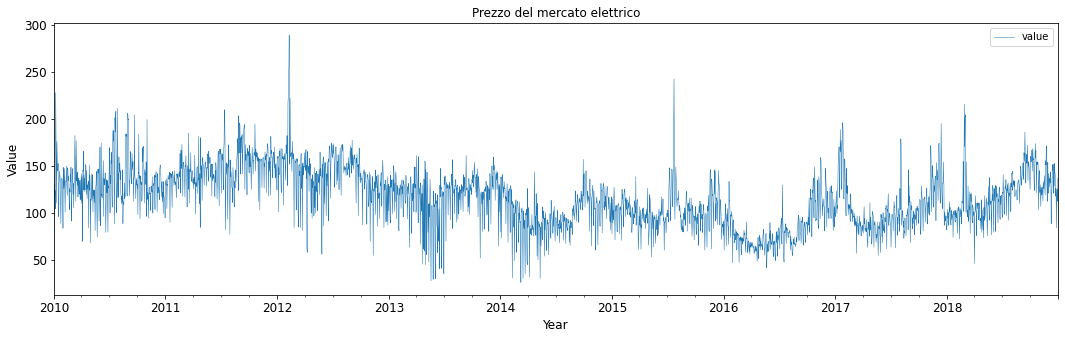

In [7]:
# Trasformazione in datetime
df.Data = pd.to_datetime(df.Data)
# Set Data as index
df = df.set_index('Data')

print("La serie storica parte da {} e termina il {}".format(min(df.index),str(max(df.index))))
print()
# Ricerca duplicati
print("Numero duplicati: {}".format(len(df[df.index.duplicated()])))

# Rappresentazione grafica della serie storica
df.plot(figsize=(18,5), linewidth=0.5, fontsize=12)
plt.title('Prezzo del mercato elettrico')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value', fontsize=12);

Si ossevano i diversi elementi della serie storica

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


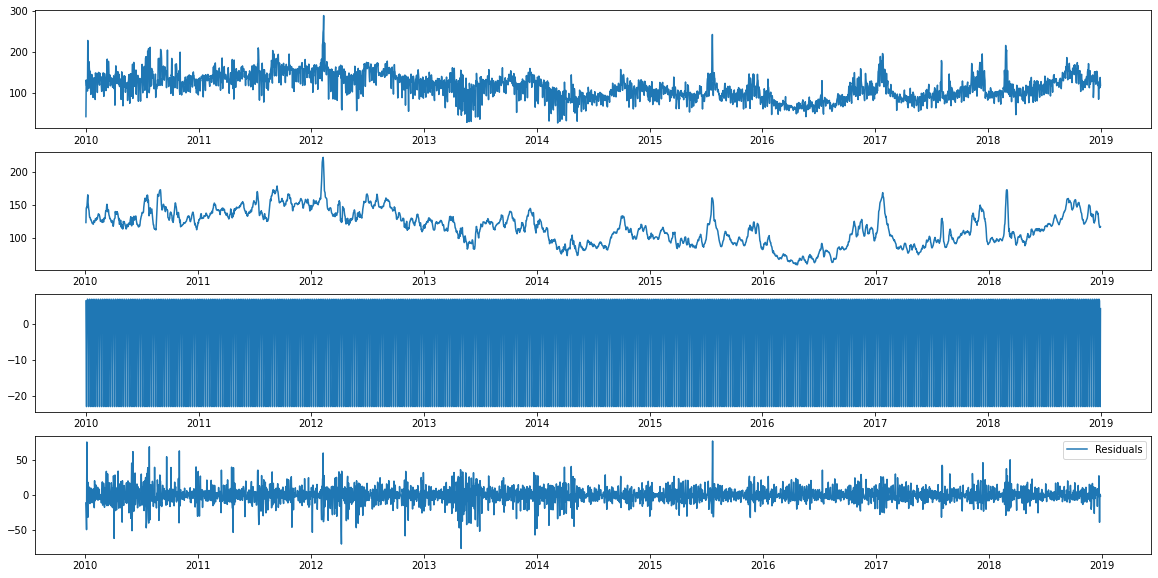

In [8]:
decomposition = seasonal_decompose(df)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4, figsize=(20,10))
axs[0].plot(df,label='Original')
plt.legend(loc='best')
axs[1].plot(trend, label='Trend')
plt.legend(loc='best')
axs[2].plot(seasonal, label='Seasonal')
plt.legend(loc='best')
axs[3].plot(residual, label='Residuals')
plt.legend(loc='best')

È possibile notare una forte stagioalità all'nterno dei dati. Come prima operazione viene calcolato il test di Dickey-Fuller per analizzare la stazionarietà della serie.

Test di Dickey-Fuller:

*   Ipotesi nulla (H0): Se non è stata rifiutata, suggerisce che la serie temporale ha una radice unitaria, il che significa che non è stazionaria. Dunque, ha una struttura dipendente dal tempo.
*  Ipotesi alternativa (H1): L'ipotesi nulla viene rifiutata; suggerisce che la serie temporale non ha una radice unitaria, il che significa che è stazionaria. Dunque, non ha una struttura dipendente dal tempo.



In [9]:
# Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller
X = df.value.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
if result[1] < 0.05:
  print_bold("L'ipotesi nulla viene rifiutata")

ADF Statistic: -3.456585
p-value: 0.009175
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
L'ipotesi nulla viene rifiutata


L'ipotesi nulla viene rifiutata. Ciò significa che la serie temporale non ha una radice unitaria e può essere considerata stazionaria. Per questo motivo non è necessario apportare alcuna trasformazione alla serie.

### Divisione in Train e Validation
Si considera l'ultimo anno come Validation Set

In [10]:
# Train fino al 31-12-2017
train = df[df.index <= ('2017-12-31')]
# Validation dal 01-01-2018 in poi
val = df[df.index > ('2017-12-31')]

Osservazioni Train: 2922 --> 88.9%
Osservazioni Validation: 365 --> 11.1%
---------------------------------


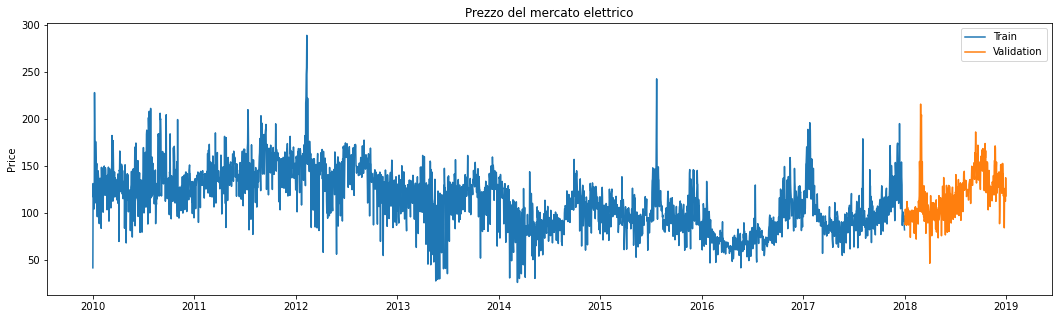

In [11]:
print("Osservazioni Train: " + str(len(train)) + ' --> ' + str(round(len(train)/len(df) * 100,2)) + '%' )
print("Osservazioni Validation: " + str(len(val)) + ' --> ' + str(round(len(val)/len(df) * 100,2)) + '%' )

print("---------------------------------")
fig = plt.figure(figsize=(18,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Prezzo del mercato elettrico')
ax.plot(train, label='Train')
ax.plot(val, label='Validation')
plt.ylabel('Price')
plt.legend()
plt.show()

## Arima

Visualizzazione dei grafici **ACF** e **PACF** per l'intera time series

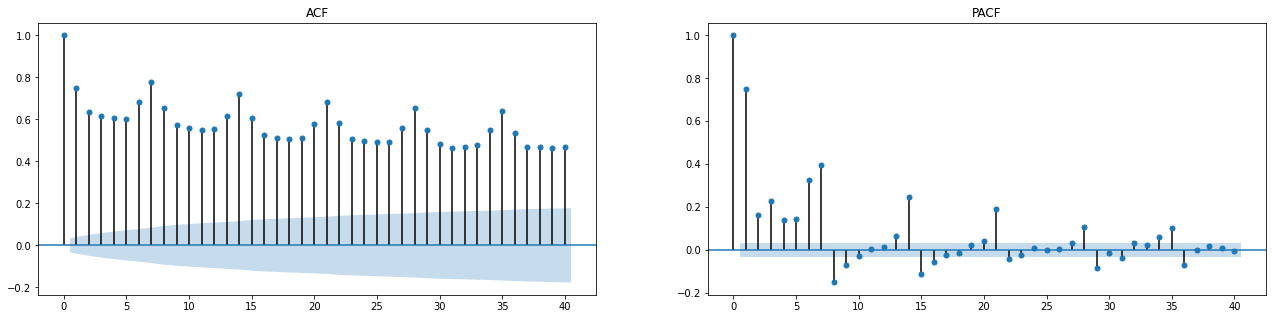

In [11]:
ACF_PACF(df)

Come ci si aspettava è possibile osservare la presenza di componenti stagionali. In particolare è possibile osservare una componente stagionale ogni sette giorni.

Viene quindi analizzato il modello **$SARIMA(0,0,0)(1,1,1)_7$**.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                            Statespace Model Results                           
Dep. Variable:                   value   No. Observations:                 2922
Model:             SARIMAX(1, 1, 1, 7)   Log Likelihood              -12446.711
Date:                 Mon, 07 Sep 2020   AIC                          24899.423
Time:                         15:26:04   BIC                          24917.347
Sample:                     01-01-2010   HQIC                         24905.880
                          - 12-31-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.2606      0.022     12.059      0.000       0.218       0.303
ma.S.L7       -0.7856      0.016    -50.349      0.000      -0.816      -0.755
sigma2       305.9186      4.779     64.013 

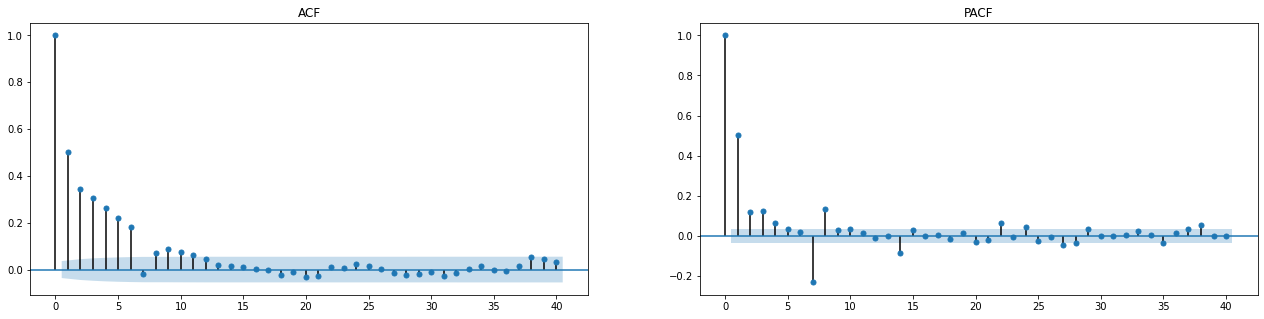

In [12]:
# SARIMA(1,0,1)_7
model = SARIMAX_def(train, p = 0, d = 0, q = 0, P = 1, D = 1, Q = 1, s = 7)
print(model.summary())

# Grafici ACF e PACF dei residui
ACF_PACF(model)

### Grid Search

L'integrazione stagionale è stata risolta. Dai grafici ACF e PACF, si può notare la presenza di un modello ARMA ma i coefficienti non sono ben identificabili (si potrebbe ipotizzare un MA(6)). Per questo motivo viene utilizzata la tecnica del **grid search** finalizzata a massimizzare la log-likelihood per trovare i giusti valori p e q per AR(p) ed MA(q).

In [13]:
best_log = -999999
for p in tqdm_notebook(range(7)):
  for q in range(7):
    # creazione del modello e fitting
    model = SARIMAX_def(train, p = p, d = 0, q = q,
                        P = 1, D = 1, Q = 1, s = 7)
    # salvataggio della log-likelihood del modello
    log = model.llf
    # controllo della log-likelihood maggiore
    if log >= best_log:
      best_log = log
      params = ((p,q))
    print('Testing AR {} - MA {} ---- Best log-likelihood: {}, (BEST ARMA {})'.format(p, q, round(best_log, 2), params))

print('----------------------------------------------------------------------------')
print()
print()
print_bold('BEST AR {} - MA {},  with log-likelihood: {}'.format(params[0], params[1], best_log))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 0 - MA 0 ---- Best log-likelihood: -12446.71, (BEST ARMA (0, 0))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 0 - MA 1 ---- Best log-likelihood: -12167.71, (BEST ARMA (0, 1))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 0 - MA 2 ---- Best log-likelihood: -12101.0, (BEST ARMA (0, 2))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 0 - MA 3 ---- Best log-likelihood: -12041.2, (BEST ARMA (0, 3))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 0 - MA 4 ---- Best log-likelihood: -12006.3, (BEST ARMA (0, 4))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 0 - MA 5 ---- Best log-likelihood: -11997.51, (BEST ARMA (0, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 0 - MA 6 ---- Best log-likelihood: -11915.82, (BEST ARMA (0, 6))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 1 - MA 0 ---- Best log-likelihood: -11915.82, (BEST ARMA (0, 6))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 1 - MA 1 ---- Best log-likelihood: -11915.82, (BEST ARMA (0, 6))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 1 - MA 2 ---- Best log-likelihood: -11884.12, (BEST ARMA (1, 2))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 1 - MA 3 ---- Best log-likelihood: -11879.57, (BEST ARMA (1, 3))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 1 - MA 4 ---- Best log-likelihood: -11875.72, (BEST ARMA (1, 4))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 1 - MA 5 ---- Best log-likelihood: -11871.01, (BEST ARMA (1, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 1 - MA 6 ---- Best log-likelihood: -11871.01, (BEST ARMA (1, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 2 - MA 0 ---- Best log-likelihood: -11871.01, (BEST ARMA (1, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 2 - MA 1 ---- Best log-likelihood: -11871.01, (BEST ARMA (1, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 2 - MA 2 ---- Best log-likelihood: -11871.01, (BEST ARMA (1, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 2 - MA 3 ---- Best log-likelihood: -11871.01, (BEST ARMA (1, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 2 - MA 4 ---- Best log-likelihood: -11871.01, (BEST ARMA (1, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 2 - MA 5 ---- Best log-likelihood: -11866.41, (BEST ARMA (2, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 2 - MA 6 ---- Best log-likelihood: -11866.41, (BEST ARMA (2, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 3 - MA 0 ---- Best log-likelihood: -11866.41, (BEST ARMA (2, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 3 - MA 1 ---- Best log-likelihood: -11866.41, (BEST ARMA (2, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 3 - MA 2 ---- Best log-likelihood: -11866.41, (BEST ARMA (2, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 3 - MA 3 ---- Best log-likelihood: -11866.41, (BEST ARMA (2, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 3 - MA 4 ---- Best log-likelihood: -11866.41, (BEST ARMA (2, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 3 - MA 5 ---- Best log-likelihood: -11859.72, (BEST ARMA (3, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 3 - MA 6 ---- Best log-likelihood: -11859.72, (BEST ARMA (3, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 4 - MA 0 ---- Best log-likelihood: -11859.72, (BEST ARMA (3, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 4 - MA 1 ---- Best log-likelihood: -11859.72, (BEST ARMA (3, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 4 - MA 2 ---- Best log-likelihood: -11859.72, (BEST ARMA (3, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 4 - MA 3 ---- Best log-likelihood: -11859.72, (BEST ARMA (3, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 4 - MA 4 ---- Best log-likelihood: -11859.72, (BEST ARMA (3, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 4 - MA 5 ---- Best log-likelihood: -11857.8, (BEST ARMA (4, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 4 - MA 6 ---- Best log-likelihood: -11857.8, (BEST ARMA (4, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 5 - MA 0 ---- Best log-likelihood: -11857.8, (BEST ARMA (4, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 5 - MA 1 ---- Best log-likelihood: -11857.8, (BEST ARMA (4, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 5 - MA 2 ---- Best log-likelihood: -11857.8, (BEST ARMA (4, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 5 - MA 3 ---- Best log-likelihood: -11857.8, (BEST ARMA (4, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 5 - MA 4 ---- Best log-likelihood: -11857.8, (BEST ARMA (4, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 5 - MA 5 ---- Best log-likelihood: -11855.37, (BEST ARMA (5, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 5 - MA 6 ---- Best log-likelihood: -11855.37, (BEST ARMA (5, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 6 - MA 0 ---- Best log-likelihood: -11855.37, (BEST ARMA (5, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Testing AR 6 - MA 1 ---- Best log-likelihood: -11855.37, (BEST ARMA (5, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 6 - MA 2 ---- Best log-likelihood: -11855.37, (BEST ARMA (5, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 6 - MA 3 ---- Best log-likelihood: -11855.37, (BEST ARMA (5, 5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 6 - MA 4 ---- Best log-likelihood: -11854.03, (BEST ARMA (6, 4))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 6 - MA 5 ---- Best log-likelihood: -11854.03, (BEST ARMA (6, 4))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing AR 6 - MA 6 ---- Best log-likelihood: -11854.03, (BEST ARMA (6, 4))

----------------------------------------------------------------------------


BEST AR 6 - MA 4,  with log-likelihood: -11854.03346920532


Viene addestrato il miglior modello trovato attraverso l'utilizzo di grid search

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 0, 4)x(1, 1, 1, 7)   Log Likelihood              -11854.033
Date:                           Mon, 07 Sep 2020   AIC                          23734.067
Time:                                   15:37:01   BIC                          23811.718
Sample:                               01-01-2010   HQIC                         23762.045
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2489      0.109      2.273      0.023       0.034       0.463
ar.L2          0.0873      0.116      0.750

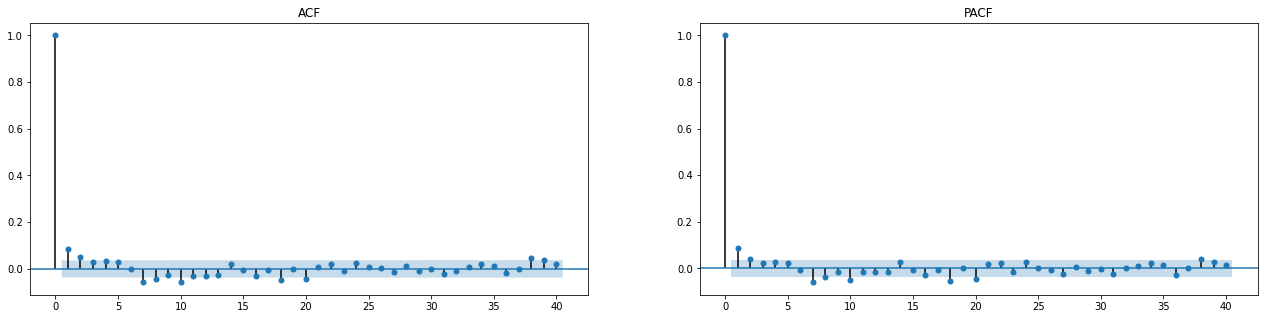

In [14]:
p = params[0]
q = params[1]
best_model = SARIMAX_def(train, p = p, d = 0, q = q,
                         P = 1, D = 1, Q = 1, s = 7)
print(best_model.summary())

# plot ACF e PACF dei residui del modello
ACF_PACF(best_model)

Dopo aver trovato i mgliori valori per i modelli AR ed MA avvero ARMA(6,4) viene testato il modello ARIMA(6,1,4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 1, 4)x(1, 1, 1, 7)   Log Likelihood              -11858.336
Date:                           Mon, 07 Sep 2020   AIC                          23742.673
Time:                                   15:37:31   BIC                          23820.319
Sample:                               01-01-2010   HQIC                         23770.650
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6634      0.175     -3.800      0.000      -1.006      -0.321
ar.L2         -0.1459      0.203     -0.719

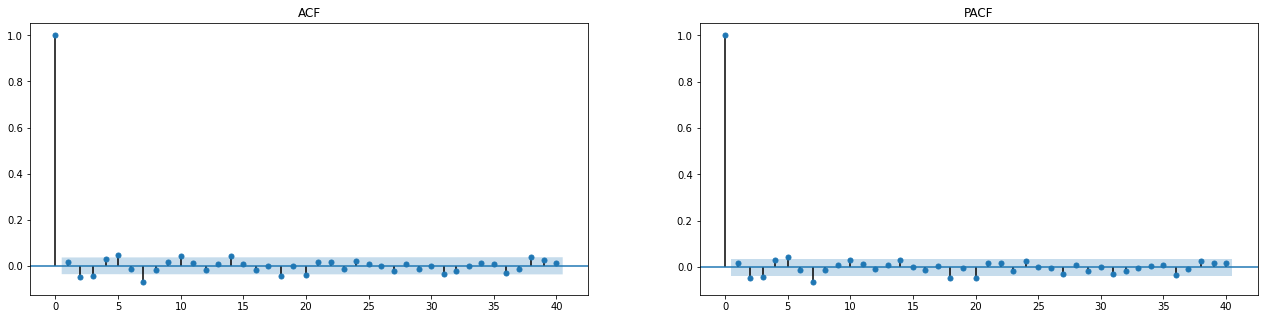

In [15]:
arima_model = SARIMAX_def(train, p = p, d = 1, q = q,
                          P = 1, D = 1, Q = 1, s = 7)
print(arima_model.summary())

# plot ACF e PACF dei residui del modello
ACF_PACF(arima_model)

È possibile osservare come i residui siano rientrati nella banda.


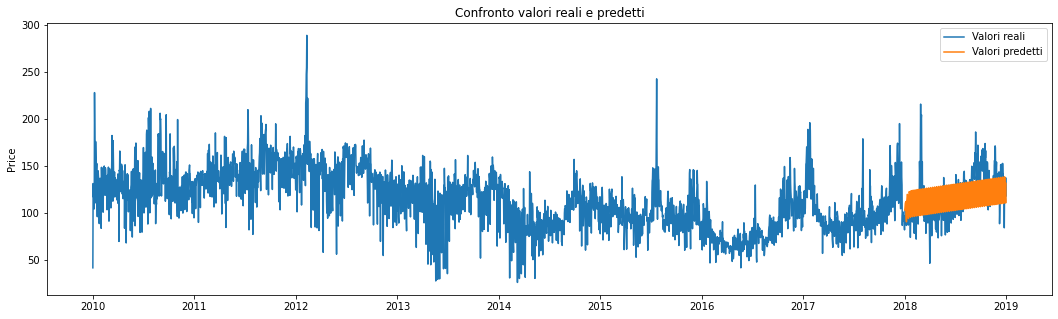

In [16]:
predict_train_arima_model = arima_model.get_prediction(start = train.index[0],
                                                       end = train.index[-1])
predict_train_arima_model = predict_train_arima_model.predicted_mean

predict_val_arima_model = arima_model.get_prediction(start=val.index[0],
                                                     end=val.index[-1])
predict_val_arima_model = predict_val_arima_model.predicted_mean

plot_ts(df, predict_val_arima_model)

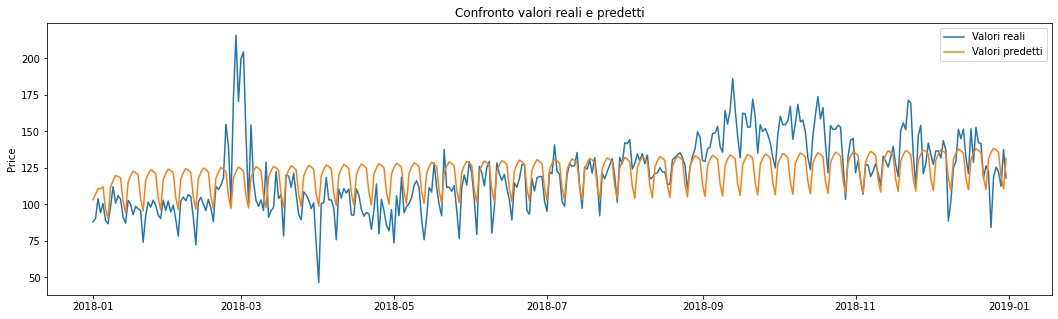

In [17]:
plot_ts(val, predict_val_arima_model)

Calcolo MAPE

In [18]:
print('------- ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_arima_model), 2))
print('MAPE Validation', round(mape(val.value, predict_val_arima_model), 2))

------- ARIMA MODEL -------
MAPE Train 9.86
MAPE Validation 13.68


### Multistagionalità

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 1, 4)x(1, 1, 1, 7)   Log Likelihood              -11862.783
Date:                           Mon, 07 Sep 2020   AIC                          23755.566
Time:                                   15:38:10   BIC                          23845.159
Sample:                               01-01-2010   HQIC                         23787.847
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin365        29.0038     12.114      2.394      0.017       5.260      52.747
cos365        80.0799     44.267      1.809

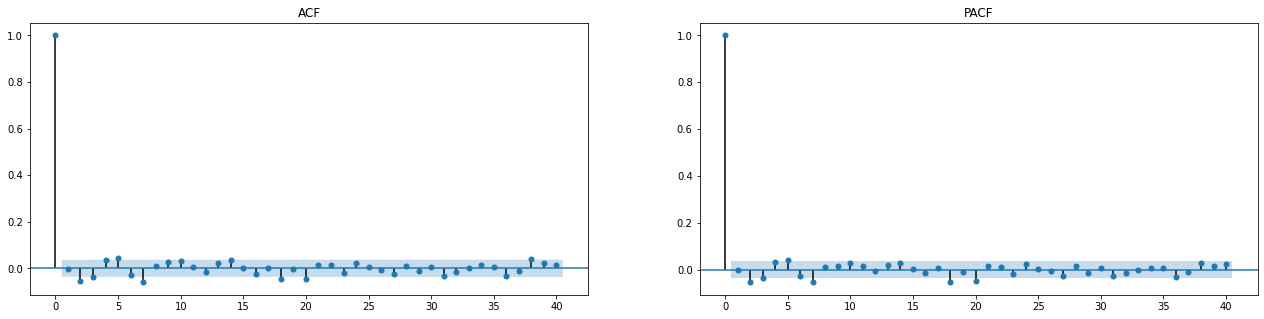

In [19]:
# Termini di Fourier
exog = pd.DataFrame({'date': df.index})
exog = exog.set_index(df.index)
exog['sin365'] = np.sin(2*np.pi*exog.index.day / 365.25)
exog['cos365'] = np.cos(2*np.pi*exog.index.day / 365.25)
# Train fino al 31-12-2017
exog_train = exog[exog.index <= ('2017-12-31')]
exog_train = exog_train.drop(columns=['date'])
# Validation dal 01-01-2018 in poi
exog_val = exog[exog.index > ('2017-12-31')]
exog_val = exog_val.drop(columns=['date'])

# Create and fit model
seasonal_model = SARIMAX_def(train, p = p, d = 1, q = q, 
                             P = 1, D = 1, Q = 1, s = 7,
                             exog = exog_train)
  
print(seasonal_model.summary())

# plot ACF e PACF dei residui del modello
ACF_PACF(seasonal_model)

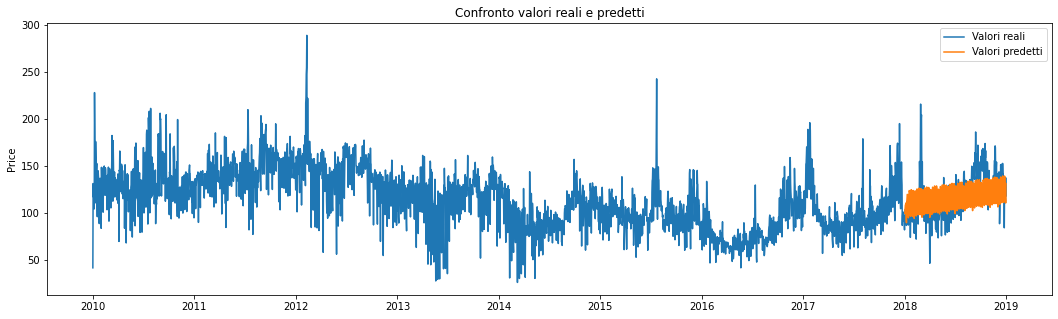

In [20]:
predict_train_seasonal_model = seasonal_model.get_prediction(start = train.index[0],
                                                             end = train.index[-1],
                                                             exog = exog_train)
predict_train_seasonal_model = predict_train_seasonal_model.predicted_mean

predict_val_seasonal_model = seasonal_model.get_prediction(start=val.index[0],
                                                           end=val.index[-1],
                                                           exog = exog_val)
predict_val_seasonal_model = predict_val_seasonal_model.predicted_mean

plot_ts(df, predict_val_seasonal_model)

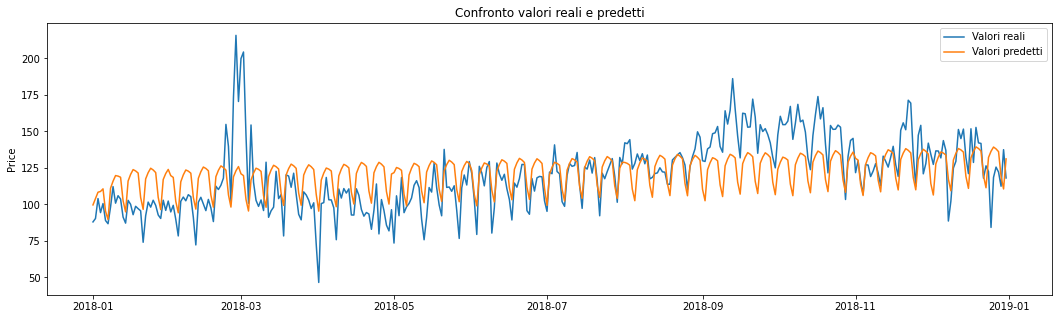

In [21]:
plot_ts(val, predict_val_seasonal_model)

Calcolo MAPE

In [22]:
print('------- Multi Seasonal ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_seasonal_model), 2))
print('MAPE Validation', round(mape(val.value, predict_val_seasonal_model), 2))

------- Multi Seasonal ARIMA MODEL -------
MAPE Train 9.87
MAPE Validation 13.67


### Regressori Holiday

Considerando che si tratta di una serie temporale rappresentate il consumo di energia elettrica può essere utile inserire dei regressori esterni per monitorare i diversi eventi come le feste.

In [23]:
# Aggiunta delle festività italiane
holiday_date = []
holiday_name = []
for h in tqdm_notebook(holidays.Italy(years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]).items()): 
    holiday_date.append(h[0])
    holiday_name.append(h[1])
  
holiday_df = pd.DataFrame(data=holiday_name, index=holiday_date)
temp = pd.concat((df, holiday_df), axis=1)
df_dummy = pd.get_dummies(temp)
df_dummy = df_dummy.set_index(df.index)
df_dummy = df_dummy.drop(["value", "0_Festa della Liberazione, Lunedì dell'Angelo"], axis = 1)

# Train fino al 31-12-2017
train_dummy = df_dummy[df_dummy.index <= ('2017-12-31')]
print('Dimensioni train:', train_dummy.shape)
# Validation dal 01-01-2018 in poi
val_dummy = df_dummy[df_dummy.index > ('2017-12-31')]
print('Dimensioni validation:', val_dummy.shape)

df_dummy.head()


Dimensioni train: (2922, 12)
Dimensioni validation: (365, 12)


,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
Data,,,,,,,,,,,,
2010-01-01,0,1,0,0,0,0,0,0,0,0,0,0
2010-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-03,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-04,0,0,0,0,0,0,0,0,0,0,0,0
2010-01-05,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 1, 4)x(1, 1, 1, 7)   Log Likelihood              -11862.067
Date:                           Mon, 07 Sep 2020   AIC                          23774.134
Time:                                   15:40:05   BIC                          23923.454
Sample:                               01-01-2010   HQIC                         23827.936
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
0_Assunzione della Vergine     0.0098      3.945      0.002      0.998      -7.723       7

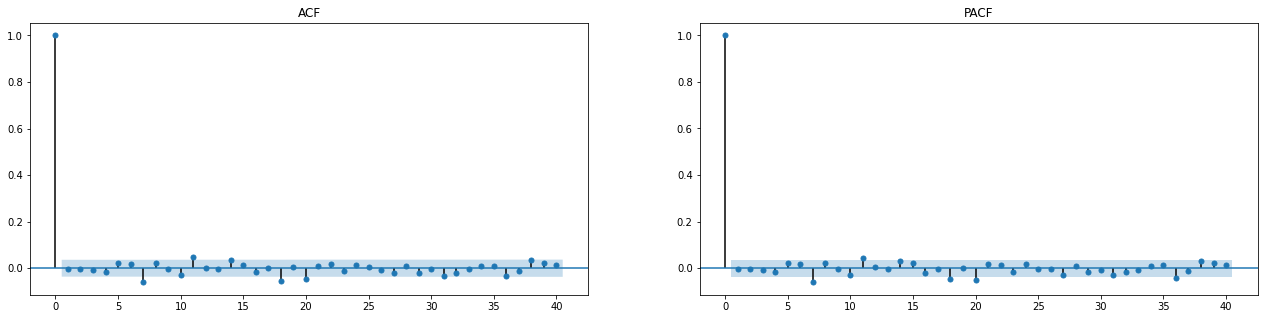

In [24]:
# create and fit model
holiday_arima_model = SARIMAX_def(train, p = p, d = 1, q = q, 
                                  P = 1, D = 1, Q = 1, s = 7,
                                  exog = train_dummy)
  
print(holiday_arima_model.summary())

# plot ACF e PACF dei residui del modello
ACF_PACF(holiday_arima_model)

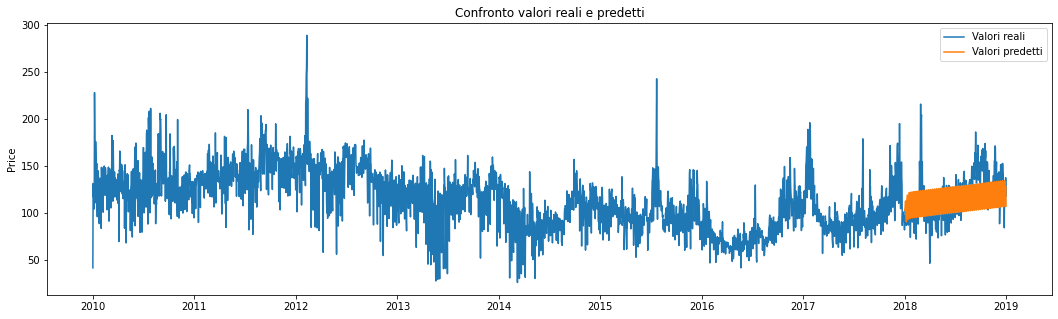

In [25]:
# predict train
predict_train_holiday_arima_model = holiday_arima_model.get_prediction(start = train.index[0],
                                                                       end = train.index[-1],
                                                                       exog = train_dummy)
predict_train_holiday_arima_model = predict_train_holiday_arima_model.predicted_mean

# predict validation
predict_val_holiday_arima_model = holiday_arima_model.get_prediction(start = val.index[0],
                                                                     end = val.index[-1],
                                                                     exog = val_dummy)
predict_val_holiday_arima_model = predict_val_holiday_arima_model.predicted_mean

# plot prediction
plot_ts(df, predict_val_holiday_arima_model)

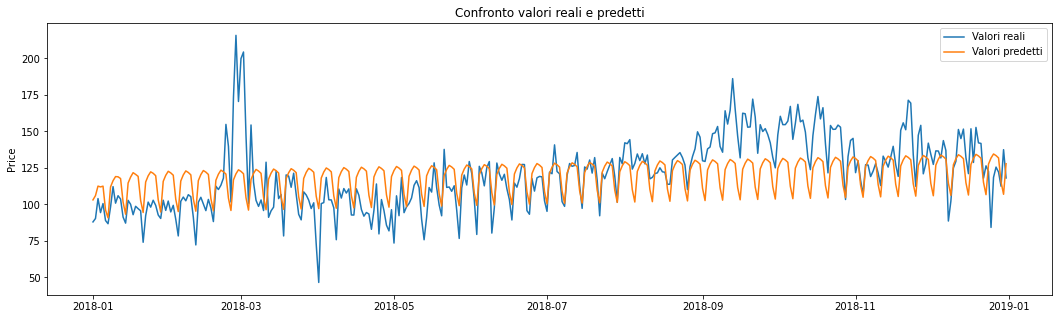

In [26]:
plot_ts(val, predict_val_holiday_arima_model)

In [27]:
print('------- Holiday Dummy ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_holiday_arima_model), 2))
print('MAPE Validation', round(mape(val.value, predict_val_holiday_arima_model), 2))

------- Holiday Dummy ARIMA MODEL -------
MAPE Train 9.85
MAPE Validation 13.45


### Multistagionalità + Holiday

Unione dei regressori stagionali e delle festività italiane

In [28]:
season_holiday_train = pd.concat((exog_train, train_dummy), axis = 1)
season_holiday_train.head()

season_holiday_val = pd.concat((exog_val, val_dummy), axis = 1)
season_holiday_val.head()

,sin365,cos365,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
Data,,,,,,,,,,,,,,
2018-01-01,0.017202,0.999852,0,1,0,0,0,0,0,0,0,0,0,0
2018-01-02,0.034398,0.999408,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-03,0.051584,0.998669,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-04,0.068755,0.997634,0,0,0,0,0,0,0,0,0,0,0,0
2018-01-05,0.085906,0.996303,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                             value   No. Observations:                 2922
Model:             SARIMAX(6, 1, 4)x(1, 1, 1, 7)   Log Likelihood              -11686.186
Date:                           Mon, 07 Sep 2020   AIC                          23426.372
Time:                                   15:42:12   BIC                          23587.638
Sample:                               01-01-2010   HQIC                         23484.478
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sin365                       -25.8843     12.338     -2.098      0.036     -50.067      -1

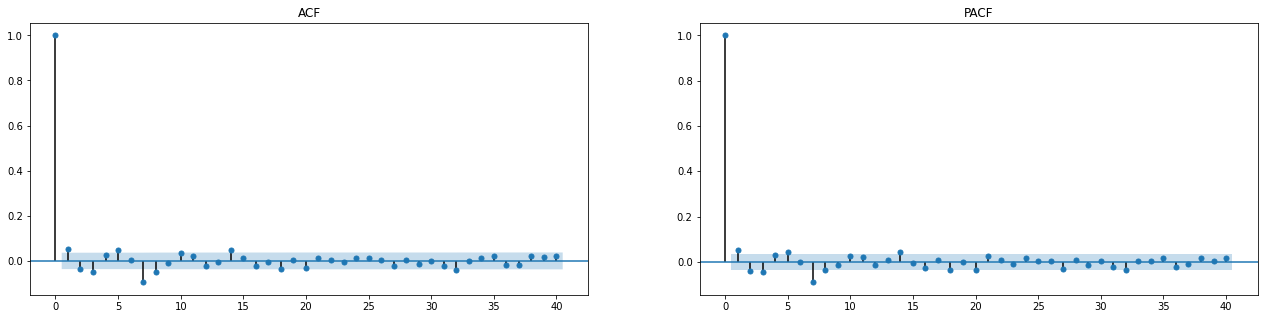

In [29]:
# crate model
season_holiday_arima_model = SARIMAX_def(train, p = p, d = 1, q = q, 
                                         P = 1, D = 1, Q = 1, s = 7,
                                         exog = season_holiday_train)
      
print(season_holiday_arima_model.summary())

# plot ACF e PACF dei residui del modello
ACF_PACF(season_holiday_arima_model)

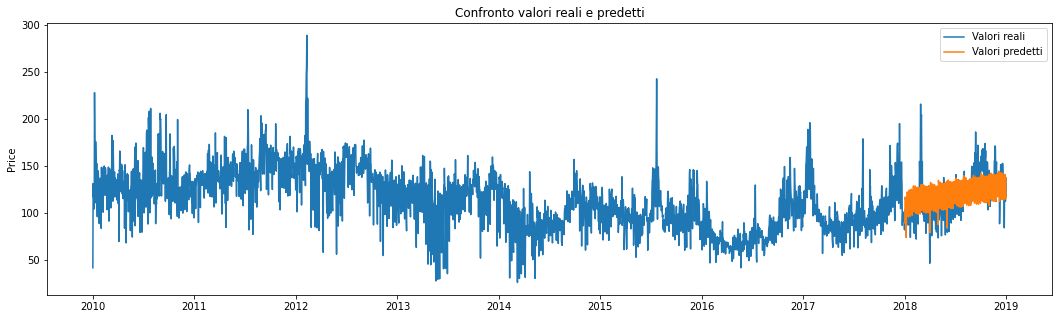

In [30]:
# prediction train
predict_train_season_holiday_arima_model = season_holiday_arima_model.get_prediction(start = train.index[0],
                                                                                     end = train.index[-1],
                                                                                     exog = season_holiday_train)
predict_train_season_holiday_arima_model = predict_train_season_holiday_arima_model.predicted_mean

# prediction validation
predict_val_season_holiday_arima_model = season_holiday_arima_model.get_prediction(start=val.index[0],
                                                                                   end=val.index[-1],
                                                                                   exog = season_holiday_val)
predict_val_season_holiday_arima_model = predict_val_season_holiday_arima_model.predicted_mean

# plot prediction validation
plot_ts(df, predict_val_season_holiday_arima_model)

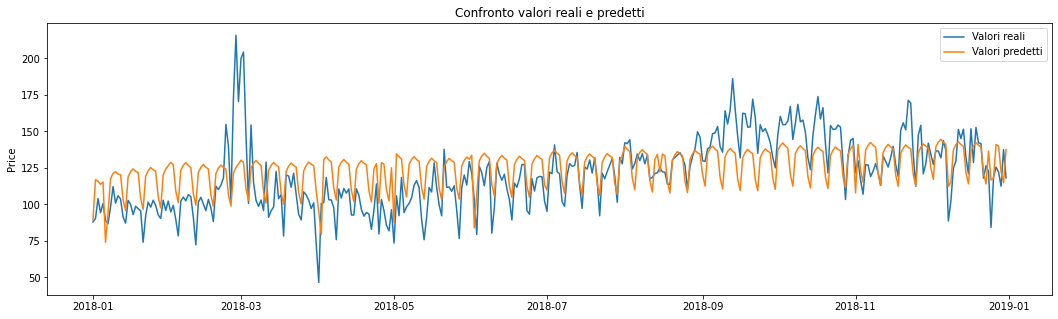

In [31]:
plot_ts(val, predict_val_season_holiday_arima_model)

Calcolo MAPE

In [32]:
print('------- Multi Seasonal and Holiday Dummy ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_season_holiday_arima_model),2))
print('MAPE Validation', round(mape(val.value, predict_val_season_holiday_arima_model),2))

------- Multi Seasonal and Holiday Dummy ARIMA MODEL -------
MAPE Train 9.41
MAPE Validation 14.2


### Confronto modelli

In [ ]:
print_bold('------- ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_arima_model), 2))
print('MAPE Validation', round(mape(val.value, predict_val_arima_model), 2))

print()

print_bold('------- Multi Seasonal ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_seasonal_model), 2))
print('MAPE Validation', round(mape(val.value, predict_val_seasonal_model), 2))

print()

print_bold('------- Holiday Dummy ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_holiday_arima_model), 2))
print('MAPE Validation', round(mape(val.value, predict_val_holiday_arima_model), 2))

print()

print_bold('------- Multi Seasonal and Holiday Dummy ARIMA MODEL -------')
print('MAPE Train', round(mape(train.value, predict_train_season_holiday_arima_model), 2))
print('MAPE Validation', round(mape(val.value, predict_val_season_holiday_arima_model), 2))

------- ARIMA MODEL -------
MAPE Train 9.86
MAPE Validation 13.68

------- Multi Seasonal ARIMA MODEL -------
MAPE Train 9.87
MAPE Validation 13.67

------- Holiday Dummy ARIMA MODEL -------
MAPE Train 9.85
MAPE Validation 13.45

------- Multi Seasonal and Holiday Dummy ARIMA MODEL -------
MAPE Train 9.41
MAPE Validation 14.2


## UCM Model

### Ricerca del trend migliore

Tramite grid search viene ricercato il miglior trend per modellare i dati minimizzando il valore di MAPE sul validation set.

In [ ]:
# Possibili trend
levels = ['llevel', # local level
          'rwalk', # random walk
          'rwdrift', # random walk con drift
          'lldtrend'] # local linear deterministic trend

# Inizializzazione best mape
best_mape = 100

# GRID SEARCH
for level in levels:
  params = {'level': level,
            'cycle': True,
            'seasonal': 7,
            'stochastic_seasonal': True}
  
  # Modello UCM
  UCM_model = UCM(train, params)

  # Prediction del validation set
  UCM_val_prediction = UCM_model.get_prediction(start = val.index[0], 
                                                end = val.index[-1])
  UCM_val_prediction = UCM_val_prediction.predicted_mean

  # Calcolo MAPE
  mape_ucm = mape(val.value, UCM_val_prediction)
  
  # Salvataggio MAPE migliore e modello migliore
  if mape_ucm < best_mape:
    best_mape = mape_ucm
    best_UCM_model = UCM_model
  
  print('-------')
  print('MAPE Validation for level', level, ':', 
        round(mape_ucm, 2), '--', 
        'Actual best MAPE:', round(best_mape,2))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


-------
MAPE Validation for level llevel : 19.44 -- Actual best MAPE: 19.44


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


-------
MAPE Validation for level rwalk : 17.63 -- Actual best MAPE: 17.63


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


-------
MAPE Validation for level rwdrift : 15.31 -- Actual best MAPE: 15.31


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


-------
MAPE Validation for level lldtrend : 19.94 -- Actual best MAPE: 15.31


In [ ]:
best_UCM_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Unobserved Components Results                            
====================================================================================
Dep. Variable:                        value   No. Observations:                 2922
Model:               random walk with drift   Log Likelihood              -12405.157
                   + stochastic seasonal(7)   AIC                          24816.314
                                    + cycle   BIC                          24834.244
Date:                      Fri, 04 Sep 2020   HQIC                         24822.774
Time:                              13:36:58                                         
Sample:                          01-01-2010                                         
                               - 12-31-2017                                         
Covariance Type:                        opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.level      271.7506      4.225     64.317      0.000     263.469     280.032
sigma2.seasonal     0.3235      0.058      5.564      0.000       0.210       0.437
frequency.cycle     3.1416   9.16e-07   3.43e+06      0.000       3.142       3.142
===================================================================================
Ljung-Box (Q):                      440.09   Jarque-Bera (JB):              3281.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Il Mape migliore viene raggiunto dal RW con Drift

In [ ]:
UCM_train_prediction, UCM_val_prediction = UCM_pred(best_UCM_model, train, val)
UCM_train_mape, UCM_val_mape = mape_train_val(train, val, UCM_train_prediction, UCM_val_prediction)

print('MAPE Train for best UCM model: {}'.format(round(UCM_train_mape, 2)))
print('MAPE Validation for best UCM model: {}'.format(round(UCM_val_mape, 2)))

MAPE Train for best UCM model: 11.1
MAPE Validation for best UCM model: 15.31


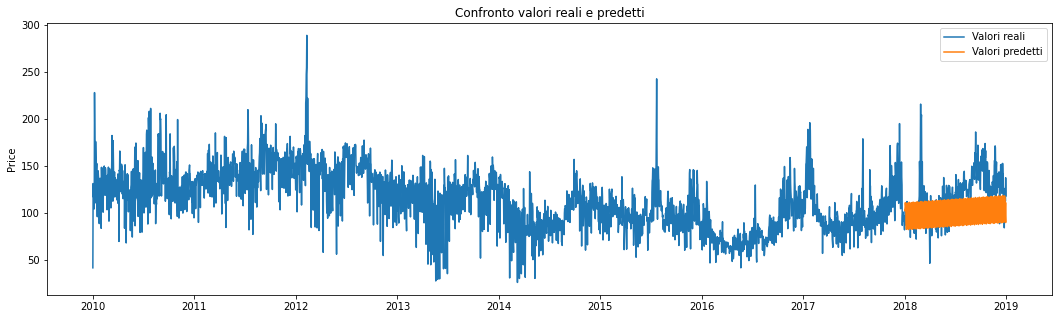

In [ ]:
plot_ts(df, UCM_val_prediction)

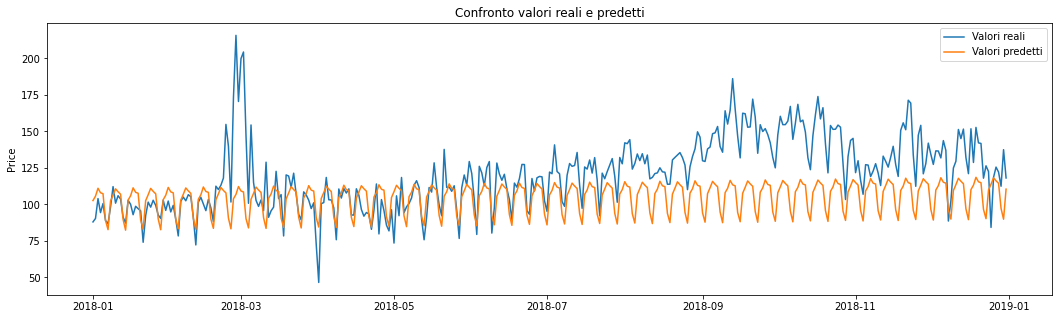

In [ ]:
plot_ts(val, UCM_val_prediction)

### Aggiunta regressori holiday

In [ ]:
params = {'level': 'rwdrift',
          'cycle': True,
          'seasonal': 7,
          'exog': train_dummy,
          'stochastic_seasonal': True}
          
UCM_model_hol = UCM(train, params)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/structural.py:1773: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


In [ ]:
UCM_hol_train_prediction, UCM_hol_val_prediction = UCM_pred(UCM_model_hol,
                                                            train,
                                                            val,
                                                            train_dummy,
                                                            val_dummy)

UCM_hol_train_mape, UCM_hol_val_mape = mape_train_val(train,
                                                      val,
                                                      UCM_hol_train_prediction,
                                                      UCM_hol_val_prediction)

print('MAPE Train for holiday UCM model: {}'.format(round(UCM_hol_train_mape, 2)))
print('MAPE Validation for holiday UCM model: {}'.format(round(UCM_hol_val_mape, 2)))

MAPE Train for holiday UCM model: 10.51
MAPE Validation for holiday UCM model: 15.88


Con i regressori holiday peggiora molto

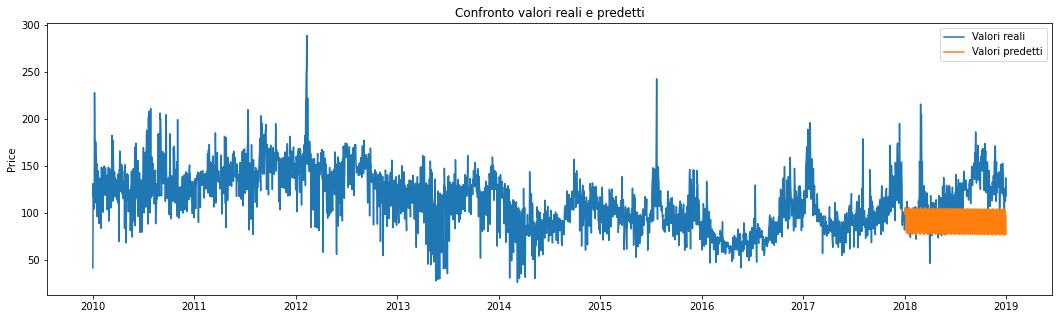

In [ ]:
plot_ts(df, UCM_val_hol_prediction)

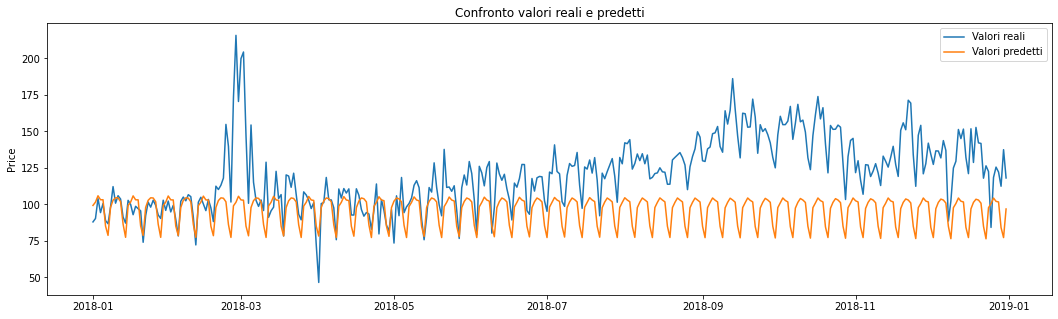

In [ ]:
plot_ts(val, UCM_val_hol_prediction)

### Aggiunta regressori stagionali

In [ ]:
params = {'level': 'rwdrift',
          'cycle': True,
          'seasonal': 7,
          'exog': exog_train,
          'stochastic_seasonal': True}

UCM_model_seas = UCM(train, params)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
UCM_seas_train_prediction, UCM_seas_val_prediction = UCM_pred(UCM_model_seas,
                                                              train,
                                                              val,
                                                              exog_train,
                                                              exog_val)

UCM_seas_train_mape, UCM_seas_val_mape = mape_train_val(train,
                                                        val,
                                                        UCM_seas_train_prediction,
                                                        UCM_seas_val_prediction)

print('MAPE Train for holiday UCM model: {}'.format(round(UCM_seas_train_mape, 2)))
print('MAPE Validation for holiday UCM model: {}'.format(round(UCM_seas_val_mape, 2)))

MAPE Train for holiday UCM model: 11.1
MAPE Validation for holiday UCM model: 16.38


Anche con i termini di fourier peggiora. La loro combinazione non viene testata.

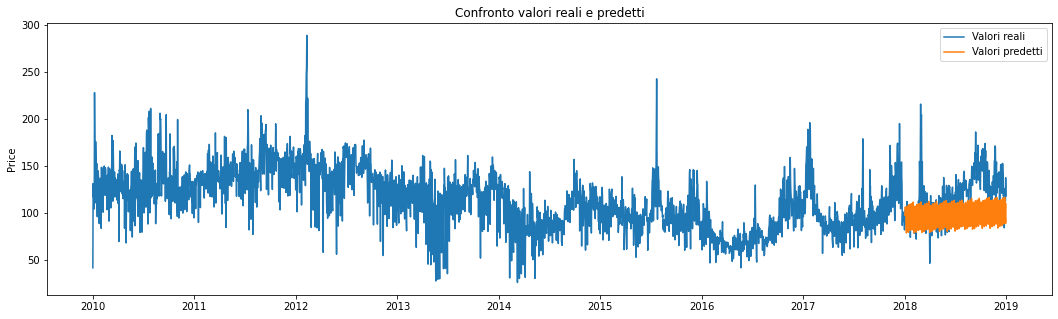

In [ ]:
plot_ts(df, UCM_seas_val_prediction)

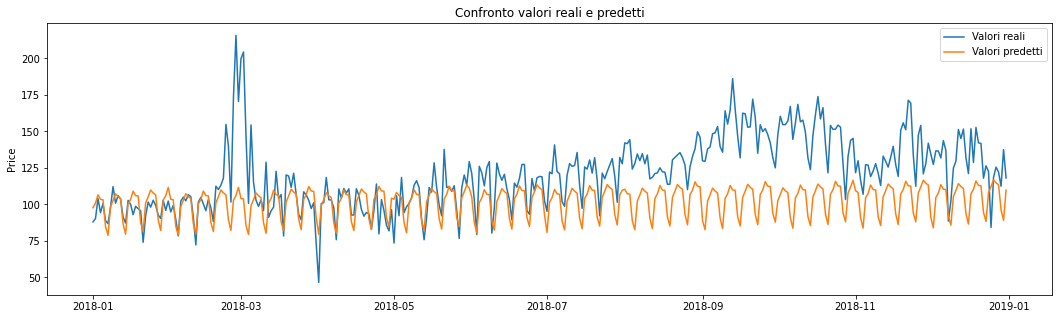

In [ ]:
plot_ts(val, UCM_seas_val_prediction)

### Sinusoidi

Per modellare la stagionalità viene testato l'utilizzo di sinusoidi

In [ ]:
params = {'level': 'rwdrift',
          'cycle': True,
          'seasonal': 7,
          'freq_seasonal': [{'period':365, 'harmonics':24}],
          'stochastic_seasonal': True}

UCM_model_freq = UCM(train, params)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [ ]:
UCM_freq_train_prediction, UCM_freq_val_prediction = UCM_pred(UCM_model_freq,
                                                              train,
                                                              val)

UCM_freq_train_mape, UCM_freq_val_mape = mape_train_val(train, 
                                                        val,
                                                        UCM_freq_train_prediction,
                                                        UCM_freq_val_prediction)

print('MAPE Train for harmonics UCM model: {}'.format(round(UCM_freq_train_mape, 2)))
print('MAPE Validation for harmonics UCM model: {}'.format(round(UCM_freq_val_mape, 2)))

MAPE Train for harmonics UCM model: 13.06
MAPE Validation for harmonics UCM model: 14.95


Il MAPE ottenuto risulta migliore rispetto ai precedenti modelli UCM che utilizzavano i regressori. Dunque questo può essere ritenuto il miglior modello.

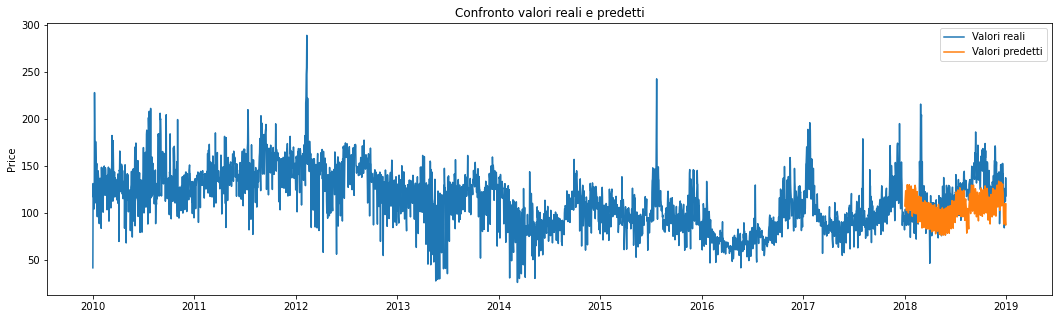

In [ ]:
plot_ts(df, UCM_freq_val_prediction)

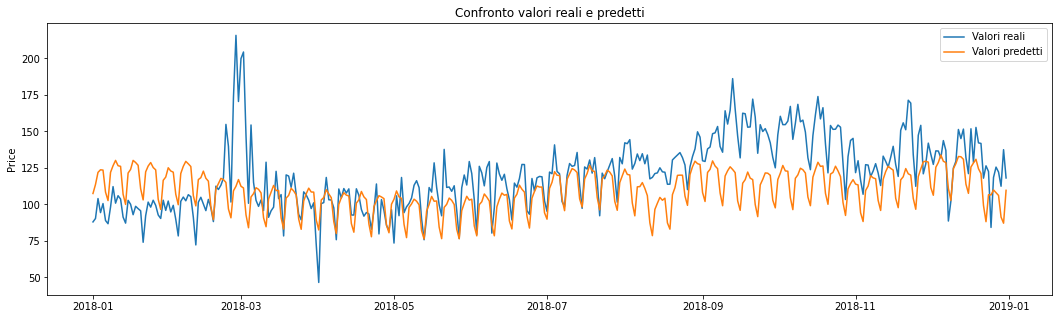

In [ ]:
plot_ts(val, UCM_freq_val_prediction)

## RNN

### Preparazione dei dati

Conversione dei dati in array

In [12]:
train_rnn = train.value.values
val_rnn = val.value.values

train_rnn = train_rnn.reshape(-1, 1)
val_rnn = val_rnn.reshape(-1, 1)

In [13]:
print('Shape of train:', train_rnn.shape)
print('Shape of validation:', val_rnn.shape)

Shape of train: (2922, 1)
Shape of validation: (365, 1)


Normalizzazione dei dati nel range [0, 1]

In [14]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_rnn)
train_rnn = scaler.transform(train_rnn)
val_rnn = scaler.transform(val_rnn)

data = np.concatenate((train_rnn, val_rnn))

In [15]:
WINDOW = 365
x_train, y_train = sliding_data(train_rnn, WINDOW)

In [16]:
print('Shape of X train:', x_train.shape)
print('Shape of Y train:', y_train.shape)

Shape of X train: (2557, 365, 1)
Shape of Y train: (2557, 1, 1)


### AutoML

Definizione dei parametri

In [ ]:
# numero di neuroni
num_nodes_lstm = [1, 512]
num_nodes1 = [1, 512]
num_nodes2 = [1, 512]

# DropOut
dropout_val = [0.1, 0.5]

# Adam optimizer
lr = [0.0001, 0.01]

# batch size
bs = [16, 512]

param = {
        # numero di neuroni e strati
        'num_nodes_lstm': ('int', num_nodes_lstm),
        'num_nodes1': ('int', num_nodes1),
        'num_nodes2': ('int', num_nodes2),
        # Dropout
        'dropout_val': ('cont', dropout_val),
        # Optimizer
        'lr': ('cont', lr),
        # Fit model
        'bs': ('int', bs)
        }

col_name = list(param.keys())

In [ ]:
# Definizione funzione per creazione rete neurale
def create_model(num_nodes_lstm,
                 num_nodes1,
                 num_nodes2,
                 dropout_val,
                 lr):
  
  WINDOW = 365

  # Sequential model
  model = Sequential()

  # LSTM input
  model.add(LSTM(int(num_nodes_lstm), input_shape=(1, WINDOW)))
  model.add(LeakyReLU())
  model.add(Dropout(rate = dropout_val))

  # Normalization
  model.add(BatchNormalization())

  # Dense node
  model.add(Dense(int(num_nodes1),
                  activation= 'relu'))
  model.add(Dropout(rate = dropout_val))

  # Dense node
  model.add(Dense(int(num_nodes2),
                  activation= 'relu'))
  model.add(Dropout(rate = dropout_val))

  # Dense node
  model.add(Dense(1, activation = 'sigmoid'))

  # compilazione della rete
  RMSprop = keras.optimizers.RMSprop(learning_rate = lr)
  model.compile(optimizer= RMSprop,
                loss='mse',
                metrics=['mae'])

  return model

best_mape = 999
# funzione calcolo mape per AutoML
def compute_mape(num_nodes_lstm,
                 num_nodes1,
                 num_nodes2,
                 dropout_val,
                 lr,
                 bs):
  global best_mape
  WINDOW = 365
  SIZE_AHEAD = 365

  # creazione del modello
  model = create_model(num_nodes_lstm,
                       num_nodes1,
                       num_nodes2,
                       dropout_val,
                       lr)
  
  # fitting del modello
  history = model.fit(x_train.reshape(-1,1, x_train.shape[1]),
                      y_train.reshape(-1,1),
                      epochs=500,
                      batch_size= int(bs),
                      shuffle=False,
                      verbose=0,
                      callbacks = [es])
  
  # calcolo mape su validation set
  final_pred = evaluate_rnn(data = train_rnn, model = model,
                             index_pred = val.index,
                             window = WINDOW, size_ahead = SIZE_AHEAD)
  
  val_mape = mape(val.value, final_pred[0])
  
  if val_mape < best_mape:
    best_mape = val_mape
    model.save('/content/drive/My Drive/SDMTAS_Project/AutoML_rnn.h5')

  return 100 - val_mape

In [ ]:
np.random.seed(1128)

kernel_covariance = squaredExponential()
surmodel = GaussianProcess(kernel_covariance)
acq = Acquisition(mode = "ExpectedImprovement")

SMBO = GPGO(surmodel, acq, compute_mape, param)
SMBO.run(init_evals = 10, max_iter = 100)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [4.89000000e+02 1.14000000e+02 8.50000000e+01 2.74689799e-01
 6.32209209e-03 2.51000000e+02]. 	  54.36851581074183 	 86.55441238386042
init   	 [2.82000000e+02 4.62000000e+02 1.08000000e+02 4.11848204e-01
 9.26393725e-03 4.54000000e+02]. 	  32.454355427220634 	 86.55441238386042
init   	 [2.47000000e+02 2.95000000e+02 1.37000000e+02 1.77307704e-01
 1.10228761e-03 7.70000000e+01]. 	  63.450800438957884 	 86.55441238386042
init   	 [4.40000000e+02 4.73000000e+02 4.93000000e+02 1.09657702e-01
 7.52284509e-03 3.43000000e+02]. 	  23.88094298499547 	 86.55441238386042
init   	 [2.31000000e+02 3.46000000e+02 4.01000000e+02 4.70281755e-01
 3.56805506e-03 2.65000000e+02]. 	  86.55441238386042 	 86.55441238386042
init   	 [2.14000000e+02 2.70000000e+01 1.00000000e+01 4.72890872e-01
 9.29976550e-03 1.11000000e+02]. 	  83.41115799792327 	 86.55441238386042
init   	 [3.35000000e+02 3.62000000e+02 2.40000000e+02 1.68269951e-01
 4.103

In [ ]:
def df_out(parametri, mape_score, col_names):
  df = pd.DataFrame(parametri) 
  df.columns = col_names 
  df['mape_score'] = 100 - mape_score
  return df

In [ ]:
risultati = df_out(SMBO.GP.X,SMBO.GP.y, col_name)
risultati.to_csv('/content/drive/My Drive/SDMTAS_Project/result_nn4.csv')
best_model = risultati.sort_values(by = 'mape_score', ascending = True).reset_index(drop = True)

In [ ]:
best_model

,num_nodes_lstm,num_nodes1,num_nodes2,dropout_val,lr,bs,mape_score
0,370.0,326.0,313.0,0.264163,0.003455,464.0,12.861012
1,231.0,346.0,401.0,0.470282,0.003568,265.0,13.445588
2,95.0,398.0,335.0,0.268252,0.005683,161.0,13.515803
3,337.0,290.0,458.0,0.432709,0.004241,271.0,13.784609
4,183.0,351.0,366.0,0.410859,0.001312,102.0,14.016829
...,...,...,...,...,...,...,...
105,440.0,473.0,493.0,0.109658,0.007523,343.0,76.119057
106,250.0,465.0,464.0,0.458091,0.007469,67.0,76.532967
107,497.0,324.0,314.0,0.210272,0.009490,102.0,77.195805
108,262.0,426.0,434.0,0.411094,0.009714,58.0,77.336070


#### Valutazione miglior modello

In [17]:
best_rnn = load_model('/content/drive/My Drive/SDMTAS_Project/AutoML_rnn.h5')
best_rnn.summary()

Model: "sequential_236"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_236 (LSTM)              (None, 370)               1089280   
_________________________________________________________________
leaky_re_lu_236 (LeakyReLU)  (None, 370)               0         
_________________________________________________________________
dropout_536 (Dropout)        (None, 370)               0         
_________________________________________________________________
batch_normalization_236 (Bat (None, 370)               1480      
_________________________________________________________________
dense_536 (Dense)            (None, 326)               120946    
_________________________________________________________________
dropout_537 (Dropout)        (None, 326)               0         
_________________________________________________________________
dense_537 (Dense)            (None, 313)            

Valutazione MAPE su train e validation

In [18]:
SIZE_AHEAD = 365
rnn_val_pred = evaluate_rnn(data = train_rnn,
                            model = best_rnn,
                            index_pred = val.index,
                            scaler = scaler,
                            window = WINDOW,
                            size_ahead = SIZE_AHEAD)

rnn_train_pred = evaluate_rnn(data = train_rnn,
                              model = best_rnn,
                              index_pred = train[WINDOW:].index,
                              scaler = scaler,
                              window = WINDOW,
                              size_ahead = len(train_rnn)-WINDOW,
                              val_data = 0)

print("MAPE Train for best RNN model: {}".format(round(mape(train[WINDOW:].value, rnn_train_pred[0]),2)))
print("MAPE Validation for best RNN model: {}".format(round(mape(val.value, rnn_val_pred[0]),2)))

MAPE Train for best RNN model: 11.77
MAPE Validation for best RNN model: 12.86


In [19]:
print("MAPE Train for best RNN model: {}".format(round(mape(train[WINDOW:].value, rnn_train_pred[0]),2)))
print("MAPE Validation for best RNN model: {}".format(round(mape(val.value, rnn_val_pred[0]),2)))

MAPE Train for best RNN model: 11.77
MAPE Validation for best RNN model: 12.86


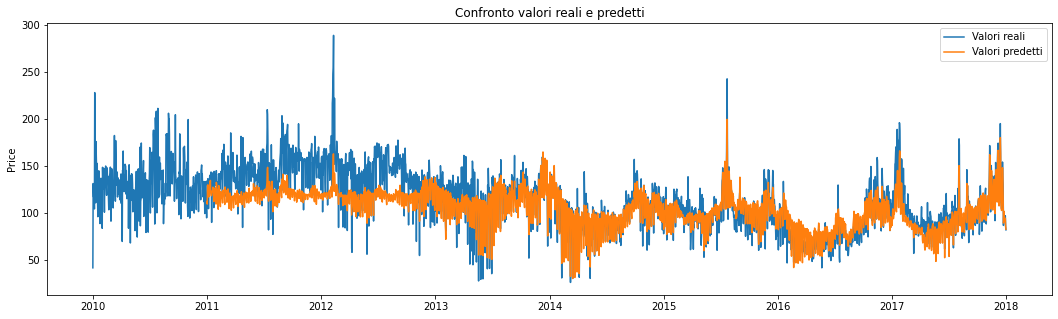

In [20]:
plot_ts(train, rnn_train_pred)

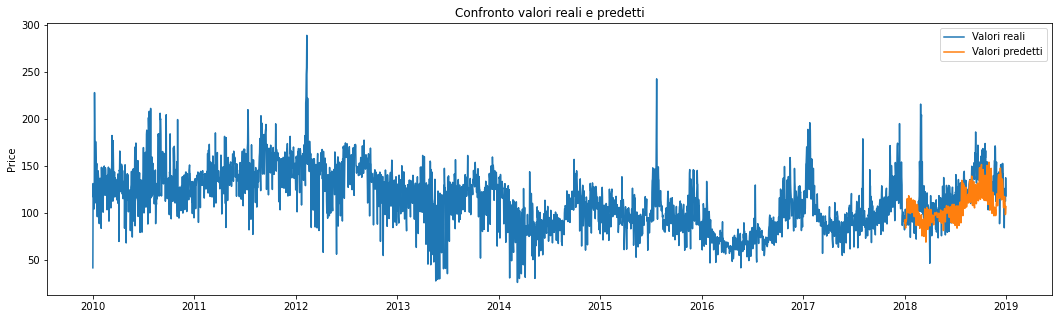

In [21]:
plot_ts(df, rnn_val_pred)

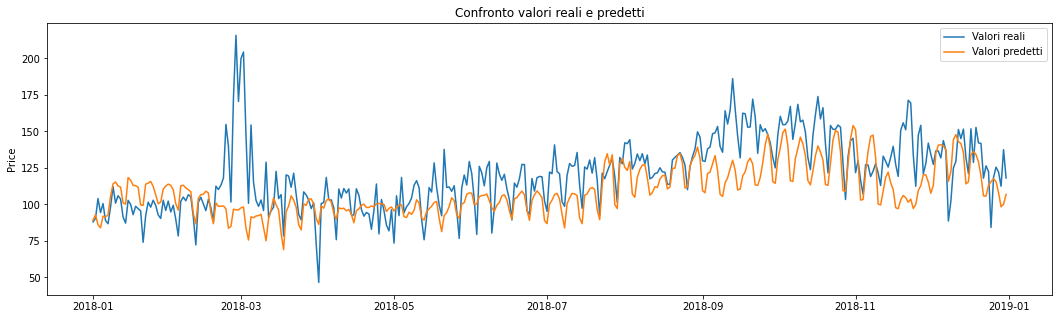

In [22]:
plot_ts(val, rnn_val_pred)

## Grafici risultati

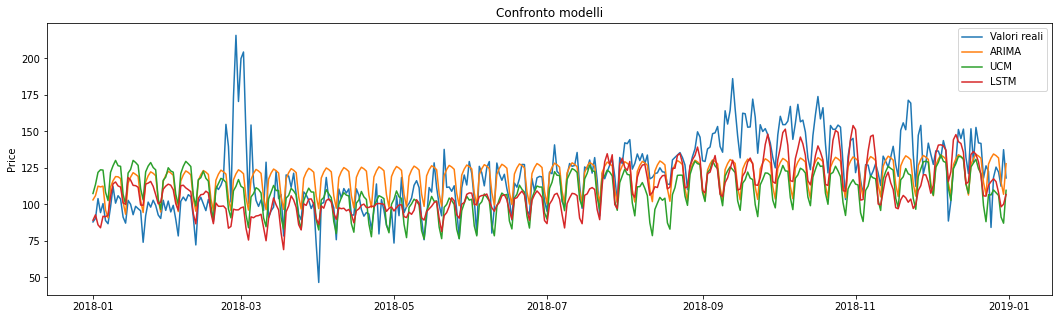

In [ ]:
fig = plt.figure(figsize=(18,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Confronto modelli')
ax.plot(val, label='Valori reali') # Reali
ax.plot(predict_val_holiday_arima_model, label='ARIMA') # ARIMA
ax.plot(UCM_freq_val_prediction, label='UCM') # UCM
ax.plot(rnn_val_pred, label='LSTM') # LSTM

plt.ylabel('Price')
plt.legend()
plt.show()

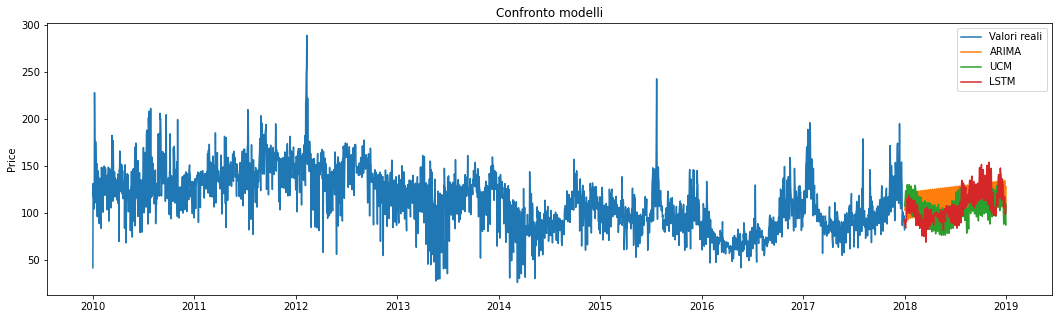

In [ ]:
fig = plt.figure(figsize=(18,5))
fig.show()
ax = fig.add_subplot(111)
plt.title('Confronto modelli')
ax.plot(train, label='Valori reali') # Reali
ax.plot(predict_val_holiday_arima_model, label='ARIMA') # ARIMA
ax.plot(UCM_freq_val_prediction, label='UCM') # UCM
ax.plot(rnn_val_pred, label='LSTM') # LSTM

plt.ylabel('Price')
plt.legend()
plt.show()

## Predizioni TEST

Fine ultimo del progetto è effettuare delle predizioni sul periodo 01-01-2019 siano al 30-11-2019. Per fare ciò i modelli vengono ri-addestrati su tutto il set di dati a disposizione

### ARIMA

Il modello migliore risulta essere Arima con l'utilizzo dei regressori dummy delle festività.

Vengono creati i regressori del test:

In [ ]:
test = pd.date_range(start='01-01-2019', end='30-11-2019')
holiday_date = []
holiday_name = []
for h in tqdm_notebook(holidays.Italy(years = [2019]).items()): 
    holiday_date.append(h[0])
    holiday_name.append(h[1])
holiday_test = pd.DataFrame(data=holiday_name, index=holiday_date)

temp = pd.concat((pd.DataFrame(test, index = test), holiday_test), axis=1)
exog = pd.get_dummies(temp)
exog = exog.dropna()
exog.drop([0], axis = 1, inplace = True)
exog

,0_Assunzione della Vergine,0_Capodanno,0_Epifania del Signore,0_Festa dei Lavoratori,0_Festa della Liberazione,0_Festa della Repubblica,0_Immacolata Concezione,0_Lunedì dell'Angelo,0_Natale,0_Pasqua di Resurrezione,0_Santo Stefano,0_Tutti i Santi
2019-01-01,0,1,0,0,0,0,0,0,0,0,0,0
2019-01-02,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-03,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-04,0,0,0,0,0,0,0,0,0,0,0,0
2019-01-05,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-26,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-27,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-28,0,0,0,0,0,0,0,0,0,0,0,0
2019-11-29,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# create and fit model
ARIMA_final = SARIMAX_def(df, p = 6, d = 1, q = 4, 
                                  P = 1, D = 1, Q = 1, s = 7,
                                  exog = df_dummy)

# Prediction test
ARIMA_final_pred = ARIMA_final.get_prediction(start = test[0],
                                            end = test[-1],
                                            exog = exog)
ARIMA_final_pred = ARIMA_final_pred.predicted_mean

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


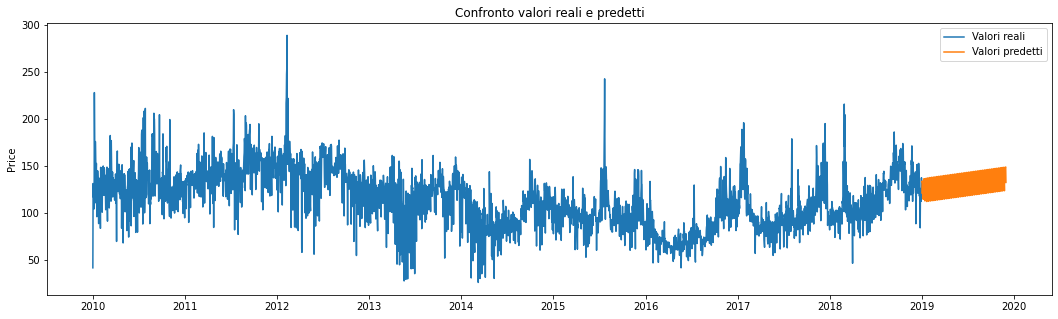

In [ ]:
plot_ts(df, ARIMA_final_pred)

### UCM

In [ ]:
# definizione parametri
params = {'level': 'rwdrift',
          'cycle': True,
          'seasonal': 7,
          'freq_seasonal': [{'period':365, 'harmonics':24}],
          'stochastic_seasonal': True}

# train e fit del modello
UCM_final = UCM(df, params)                                                   

# test prediction
UCM_final_pred = UCM_final.get_prediction(start=test[0],
                                        end=test[-1])
UCM_final_pred = UCM_final_pred.predicted_mean

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


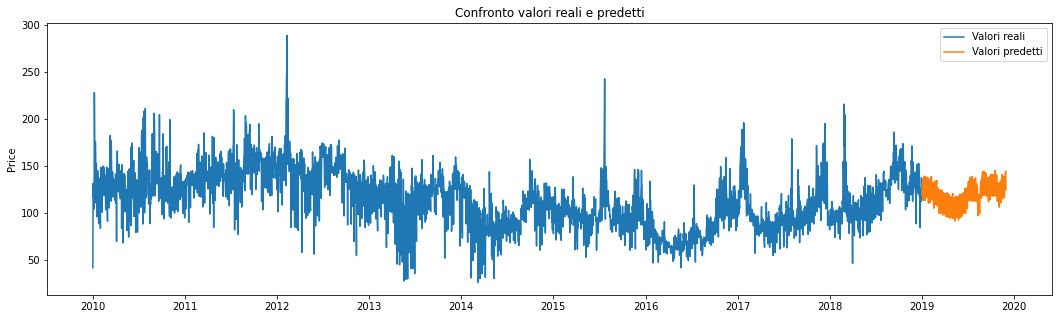

In [ ]:
plot_ts(df, UCM_final_pred)

### LSTM

Viene utilizzato lo stesso modello aggiungendo i dati del validation set

In [ ]:
RNN_final = load_model('/content/drive/My Drive/SDMTAS_Project/AutoML_rnn.h5')

In [ ]:
rnn_data = df[df.index > ('2016-12-31')]
rnn_data = rnn_data.value.values
rnn_data = rnn_data.reshape(-1, 1)
rnn_data = scaler.transform(rnn_data)
print('New data:', rnn_data.shape)
x_rnn, y_rnn = sliding_data(rnn_data, WINDOW)
print('Shape x: {}, Shape y: {}'.format(x_rnn.shape, y_rnn.shape))

New data: (730, 1)
shape x: (365, 365, 1), shape y: (365, 1, 1)


In [ ]:
RNN_final.fit(x_rnn.reshape(-1,1, x_rnn.shape[1]),
            y_rnn.reshape(-1,1),
            epochs = 200)

Epoch 1/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0046 - mean_absolute_error: 0.0517
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0036 - mean_absolute_error: 0.0444
Epoch 3/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0045 - mean_absolute_error: 0.0463
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0036 - mean_absolute_error: 0.0432
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0033 - mean_absolute_error: 0.0422
Epoch 6/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0391
Epoch 7/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0410
Epoch 8/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0395
Epoch 9/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0412
Epoch 10/2

In [ ]:
test = pd.date_range(start='01-01-2019', end='30-11-2019')
test = pd.DataFrame(test, index = test)
test = test.drop([0], axis = 1)

In [ ]:
len(test.index)

334

In [ ]:
SIZE_AHEAD = len(test)

data_pred = rnn_data[-WINDOW:]
for i in range(SIZE_AHEAD):
  to_pred = data_pred[-WINDOW:]
  pred = RNN_final.predict(to_pred.reshape(1,1,-1))
  data_pred = np.append(data_pred, pred)

RNN_final_pred = data_pred[-SIZE_AHEAD:]
RNN_final_pred = scaler.inverse_transform(RNN_final_pred.reshape(-1,1))
RNN_final_pred = pd.DataFrame(RNN_final_pred, index = test.index)

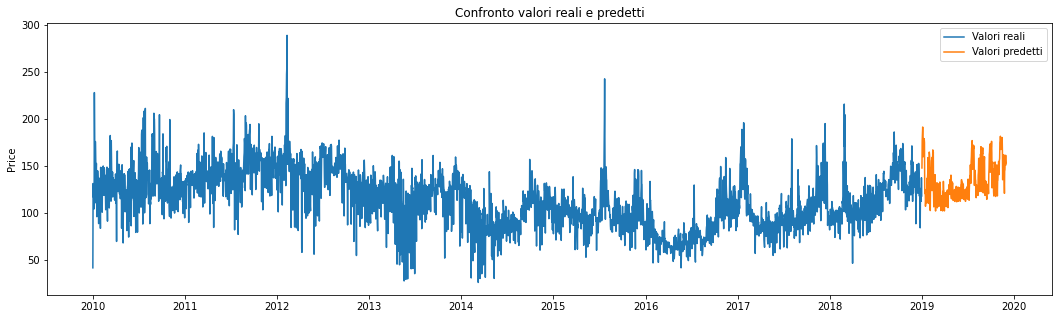

In [ ]:
plot_ts(df, RNN_final_pred)

### DF consegna

In [ ]:
Data = pd.date_range(start='01-01-2019', end='30-11-2019')
Data = pd.DataFrame(Data, index = Data)

df_consegna = pd.concat([Data,
                        ARIMA_final_pred, 
                        UCM_final_pred,
                        RNN_final_pred],
                        axis=1)

df_consegna.columns = ['Data','ARIMA', 'UCM', 'ML']
df_consegna = df_consegna.reset_index().drop('index', axis=1)
df_consegna

,Data,ARIMA,UCM,ML
0,2019-01-01,121.167398,119.284170,147.809352
1,2019-01-02,134.080172,126.703216,176.912546
2,2019-01-03,132.945659,131.349016,184.318384
3,2019-01-04,131.340466,135.725511,191.366008
4,2019-01-05,121.660235,117.111977,181.425067
...,...,...,...,...
329,2019-11-26,145.417039,135.144631,145.593031
330,2019-11-27,147.655881,141.580078,158.038156
331,2019-11-28,148.510702,143.430023,152.413709
332,2019-11-29,148.868005,144.506185,161.352090


In [ ]:
df_consegna.to_csv('/content/drive/My Drive/SDMTAS_Project/SDMTSA_807547_0.csv')